### NYC Taxi dataset:

Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. Our goal is to use TF as the ML Framework to build a pipeline which should be capable of scaling on infinite data to make an enterprise scale model.
                


In [1]:
# Owner - Hasan Rafiq
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


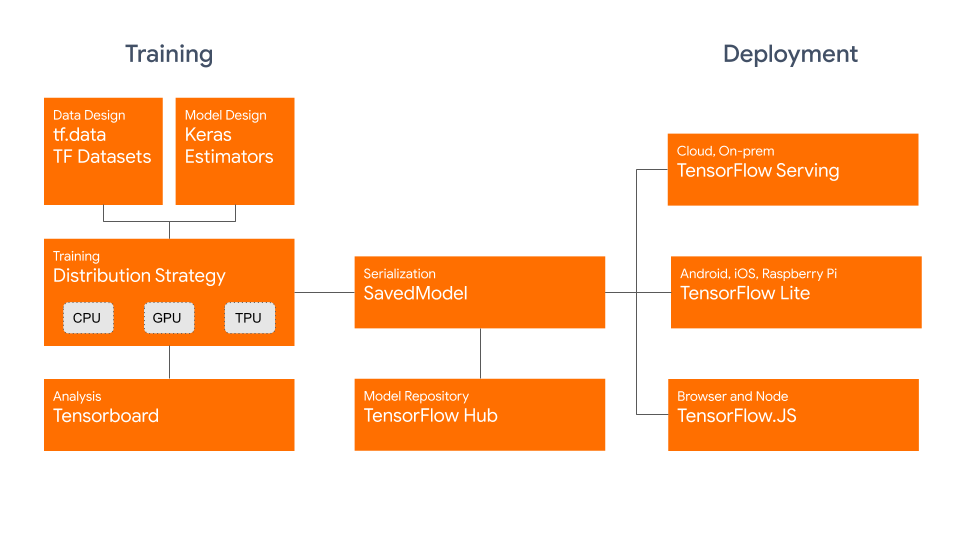

In [2]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-04-26 05:25:45--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.06s   

2021-04-26 05:25:46 (29.5 MB/s) - ‘data.csv’ saved [1922812/1922812]



## **ML Workflow:**

A typical ML workflow is an experimentive iterative process which requires building multiple models until the accuracy metrics start meeting the goals. It starts from Data gathering and goes all the way from Modeling to deployment and testing.
1. Data processing( Cleansing / Descriptive statistics )
2. Data exploration( EDA / VDA )
3. Data ingestion pipeline( TF.Data )
4. Model training & hyperparameter tuning( TF.Keras )
5. Deployment( TF Model server )

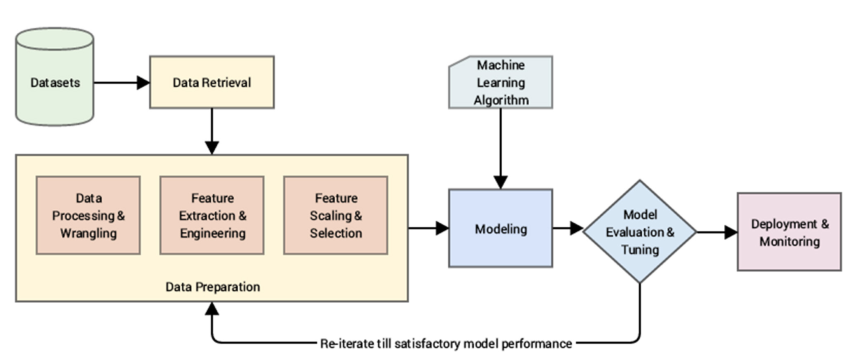

### Data - Loading and Preprocessing

This step has the new features created for the entire dataset for taxi fare prediction as previously the other dataset had only 15k records.

Preprocessed the data to create time features and then ingest into data pipeline

# Running for the original dataset

In [3]:

# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/My Drive/DeepLearning/TaxiDataset/train.csv', sep=',',nrows=150000)
train.head()

key  ...  passenger_count
0    2009-06-15 17:26:21.0000001  ...                1
1    2010-01-05 16:52:16.0000002  ...                1
2   2011-08-18 00:35:00.00000049  ...                2
3    2012-04-21 04:30:42.0000001  ...                1
4  2010-03-09 07:51:00.000000135  ...                1

[5 rows x 8 columns]

In [6]:
train.describe()

fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  150000.000000     150000.000000  ...     149999.000000    150000.000000
mean       11.361849        -72.500714  ...         39.928809         1.680407
std         9.870671         10.586363  ...          6.110042         1.305797
min       -44.900000       -736.550000  ...        -74.015160         0.000000
25%         6.000000        -73.992028  ...         40.734126         1.000000
50%         8.500000        -73.981732  ...         40.753243         1.000000
75%        12.500000        -73.966989  ...         40.768088         2.000000
max       500.000000         40.787575  ...        404.616667         6.000000

[8 rows x 6 columns]

In [7]:
print("old size: %d" % len(train))
train = train[train.fare_amount >=0]
print("New size: %d" % len(train))
# check missing data
print(train.isnull().sum())

old size: 150000
New size: 149990
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [8]:
print("old size: %d" % len(train))
train = train.dropna(how='any', axis=0)
print("New size after dropping missing value: %d" % len(train))

old size: 149990
New size after dropping missing value: 149989


#Appending time related features


In [9]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['trip_start_hour'] = df.pickup_datetime.dt.hour
  

    df['trip_start_month'] = df.pickup_datetime.dt.month
    df["trip_start_day"] = df.pickup_datetime.dt.weekday

    
    return df

In [10]:
train = prepare_time_features(train)

In [11]:
train

key  ...  trip_start_day
0         2009-06-15 17:26:21.0000001  ...               0
1         2010-01-05 16:52:16.0000002  ...               1
2        2011-08-18 00:35:00.00000049  ...               3
3         2012-04-21 04:30:42.0000001  ...               5
4       2010-03-09 07:51:00.000000135  ...               1
...                               ...  ...             ...
149995    2010-10-17 19:43:46.0000002  ...               6
149996   2012-09-08 04:13:00.00000049  ...               5
149997    2010-09-11 16:31:22.0000001  ...               5
149998  2012-02-19 02:05:00.000000199  ...               6
149999    2014-12-23 14:28:17.0000003  ...               1

[149989 rows x 11 columns]

In [12]:
##Drop useless columns
train = train.drop(['pickup_datetime','passenger_count','key'], axis=1)

In [13]:

train.info()
train = train[['fare_amount' ,'trip_start_month' ,'trip_start_hour' ,'trip_start_day' ,'pickup_latitude' ,'pickup_longitude' , 'dropoff_latitude' , 'dropoff_longitude']]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 149989 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        149989 non-null  float64
 1   pickup_longitude   149989 non-null  float64
 2   pickup_latitude    149989 non-null  float64
 3   dropoff_longitude  149989 non-null  float64
 4   dropoff_latitude   149989 non-null  float64
 5   trip_start_hour    149989 non-null  int64  
 6   trip_start_month   149989 non-null  int64  
 7   trip_start_day     149989 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 10.3 MB


In [14]:
train = train.rename(columns={"fare_amount": "fare" ,'trip_start_month':'trip_start_month','trip_start_hour':'trip_start_hour','trip_start_day':'trip_start_day','pickup_latitude':'pickup_latitude','pickup_longitude' :'pickup_longitude' ,'dropoff_latitude' :'dropoff_latitude','dropoff_longitude':'dropoff_longitude'})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149989 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               149989 non-null  float64
 1   trip_start_month   149989 non-null  int64  
 2   trip_start_hour    149989 non-null  int64  
 3   trip_start_day     149989 non-null  int64  
 4   pickup_latitude    149989 non-null  float64
 5   pickup_longitude   149989 non-null  float64
 6   dropoff_latitude   149989 non-null  float64
 7   dropoff_longitude  149989 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 10.3 MB


# Retaining the structure of referral dataset

In [15]:

df=train
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149989 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               149989 non-null  float64
 1   trip_start_month   149989 non-null  int64  
 2   trip_start_hour    149989 non-null  int64  
 3   trip_start_day     149989 non-null  int64  
 4   pickup_latitude    149989 non-null  float64
 5   pickup_longitude   149989 non-null  float64
 6   dropoff_latitude   149989 non-null  float64
 7   dropoff_longitude  149989 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 10.3 MB


In [16]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare'] > 200].index)

#Change datatype of cols
df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149984 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               149984 non-null  float64
 1   trip_start_month   149984 non-null  object 
 2   trip_start_hour    149984 non-null  object 
 3   trip_start_day     149984 non-null  object 
 4   pickup_latitude    149984 non-null  float64
 5   pickup_longitude   149984 non-null  float64
 6   dropoff_latitude   149984 non-null  float64
 7   dropoff_longitude  149984 non-null  float64
dtypes: float64(5), object(3)
memory usage: 10.3+ MB


In [17]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

127469
22515


### Exploratory Data Analysis



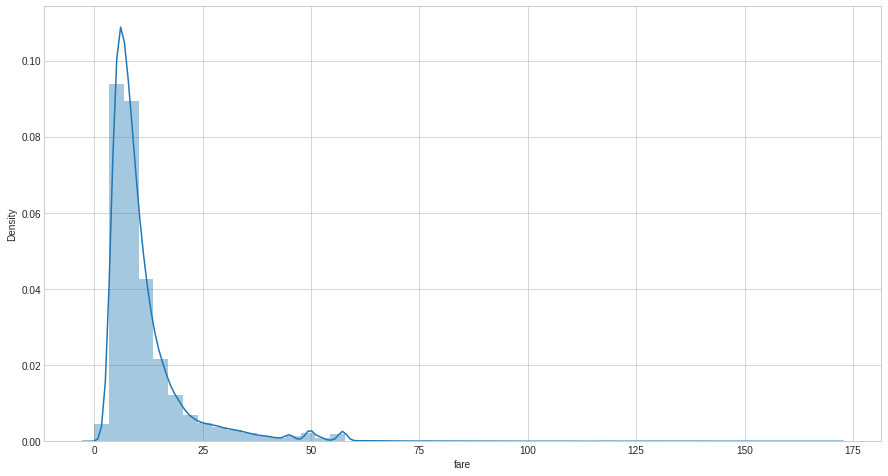

In [18]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [19]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

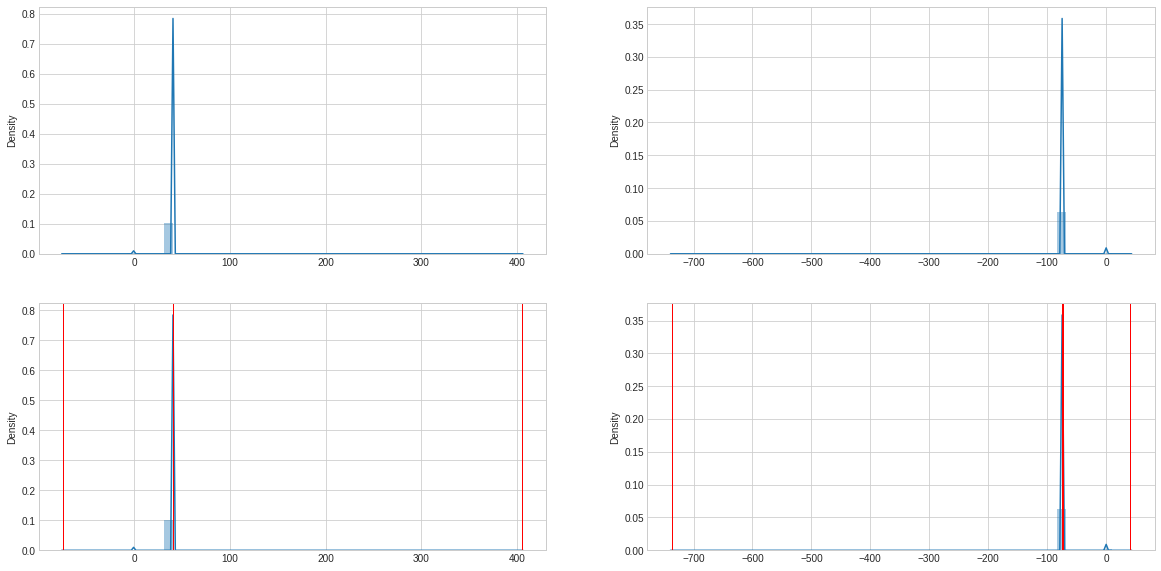

In [20]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

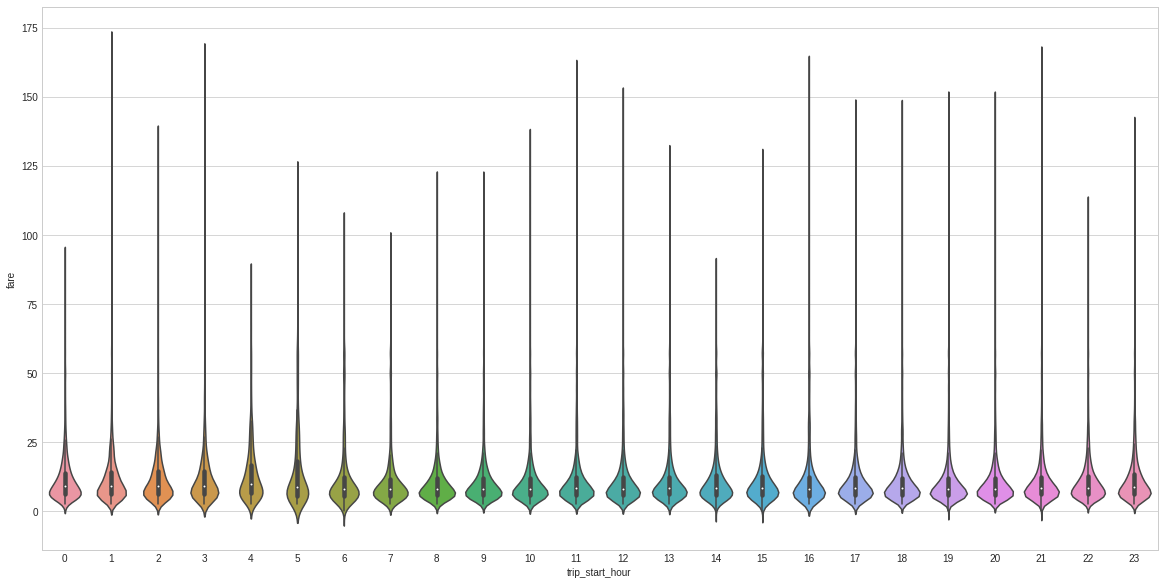

In [21]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

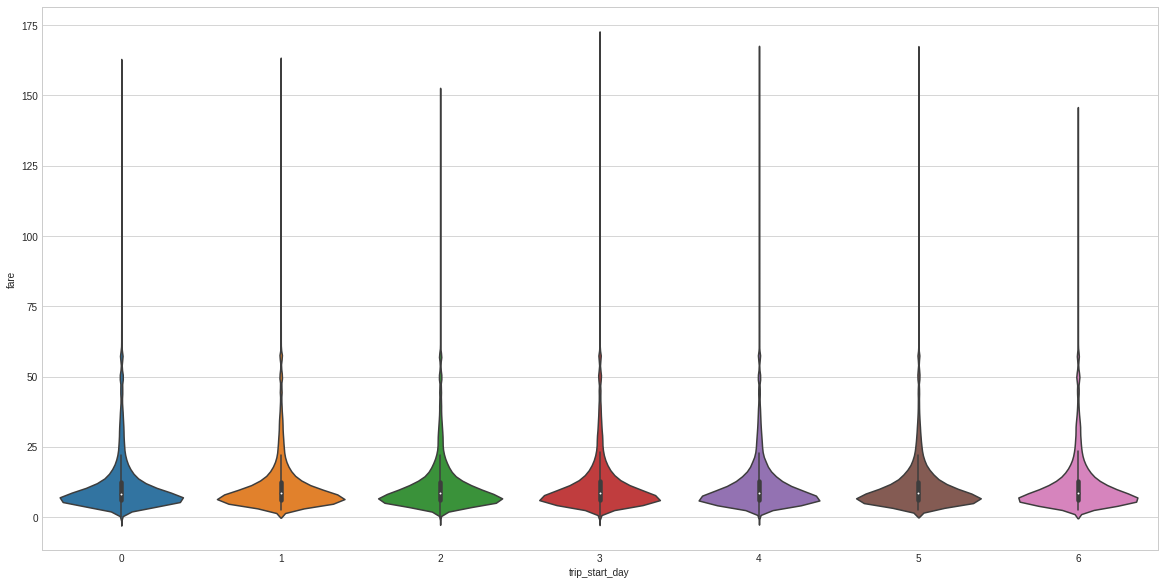

In [22]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

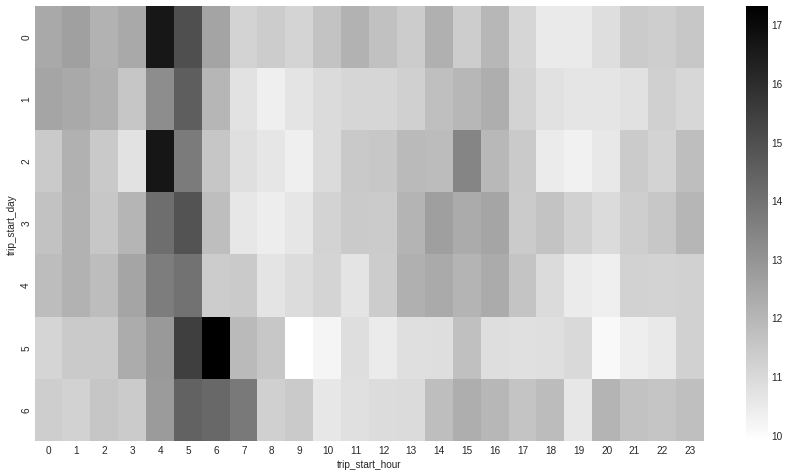

In [23]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

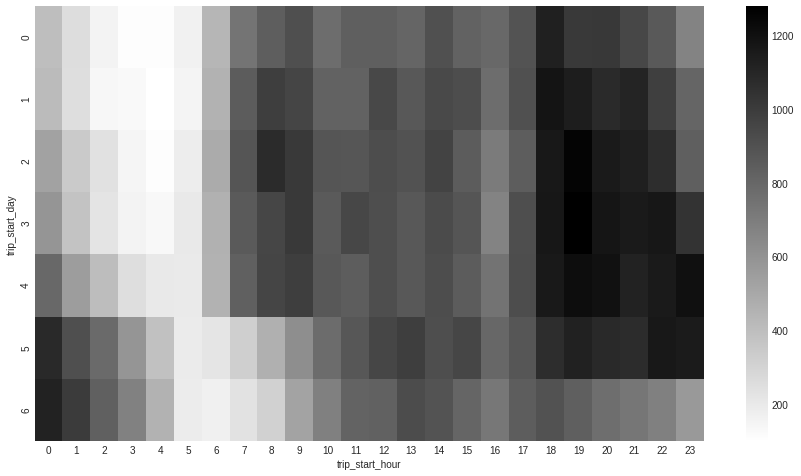

In [24]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

**Feature engineering exploration**:

Explore possible transformations that can be added as new features in the model to increase accuracy of the model and reduce training time.

In [25]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head()  

fare trip_start_month  ... dropoff_longitude  distance
0   4.5                6  ...        -73.841610  0.943584
1  16.9                1  ...        -73.979268  7.969567
2   5.7                8  ...        -73.991242  1.367404
3   7.7                4  ...        -73.991567  2.534047
4   5.3                3  ...        -73.956655  1.946952

[5 rows x 9 columns]

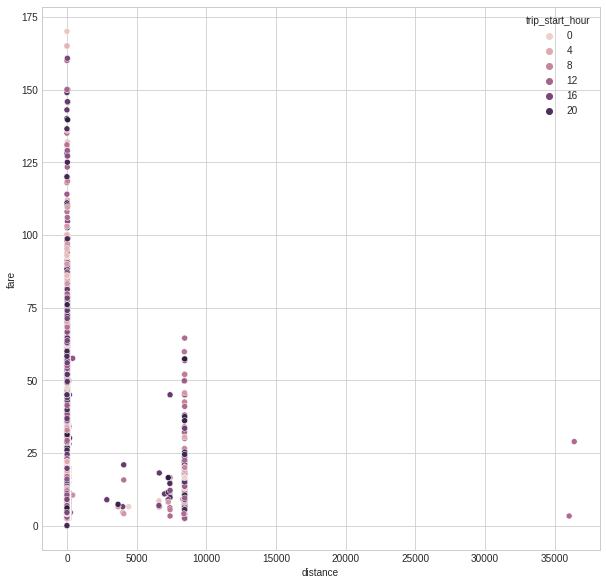

In [26]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

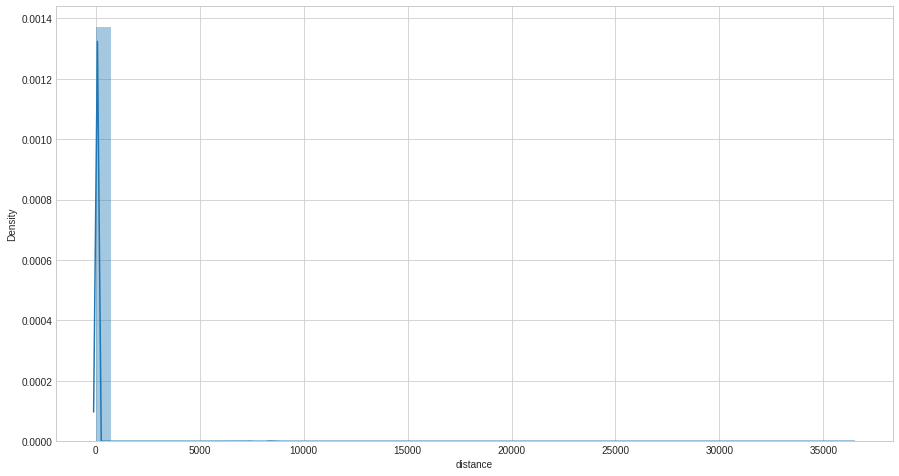

In [27]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

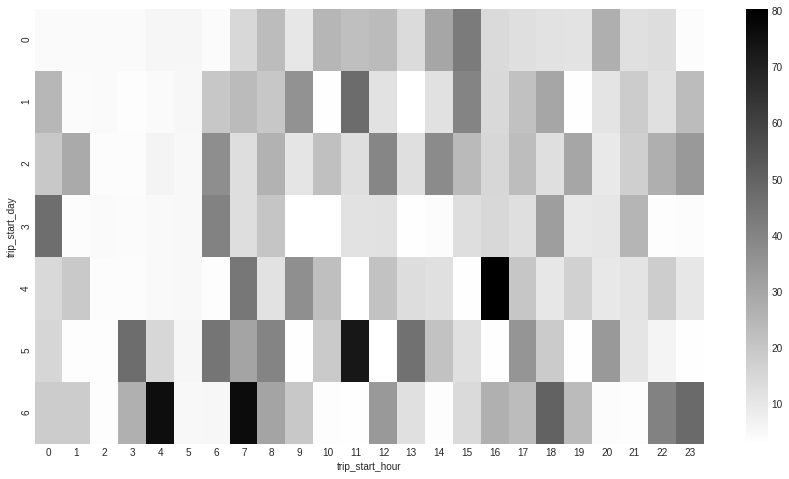

In [28]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [29]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

127469
22515


fare trip_start_month  ... dropoff_latitude dropoff_longitude
0   4.5                6  ...        40.712278        -73.841610
1  16.9                1  ...        40.782004        -73.979268
2   5.7                8  ...        40.750562        -73.991242
3   7.7                4  ...        40.758092        -73.991567
4   5.3                3  ...        40.783762        -73.956655

[5 rows x 8 columns]

### Data - **Ingestion Pipeline**

Till now, we explored the sample data in Pandas for understanding patterns, doing cleansing, pre-processing, feature engineering. However the complete training data can be much larger in size( possibly TB or more ) which can't be processed at once using Pandas.

In this step using **TF.Data** API, we setup a **pipeline** which reads data in **batches** from infinite-sized files or other data sources, applies transformations( feature engineering etc. ) and the result data is then directly fed as input to an algorithm for model training.

There are some best practices to be incorporated when using TF Data API in order to maximize the IO throughput.
1. Prefetch() -> Fetch data for next iterations in current iteration itself
2. Interleave() -> Open connections to multiple files at once( sharding )
3. Map() -> Apply transformation to input data, create new features

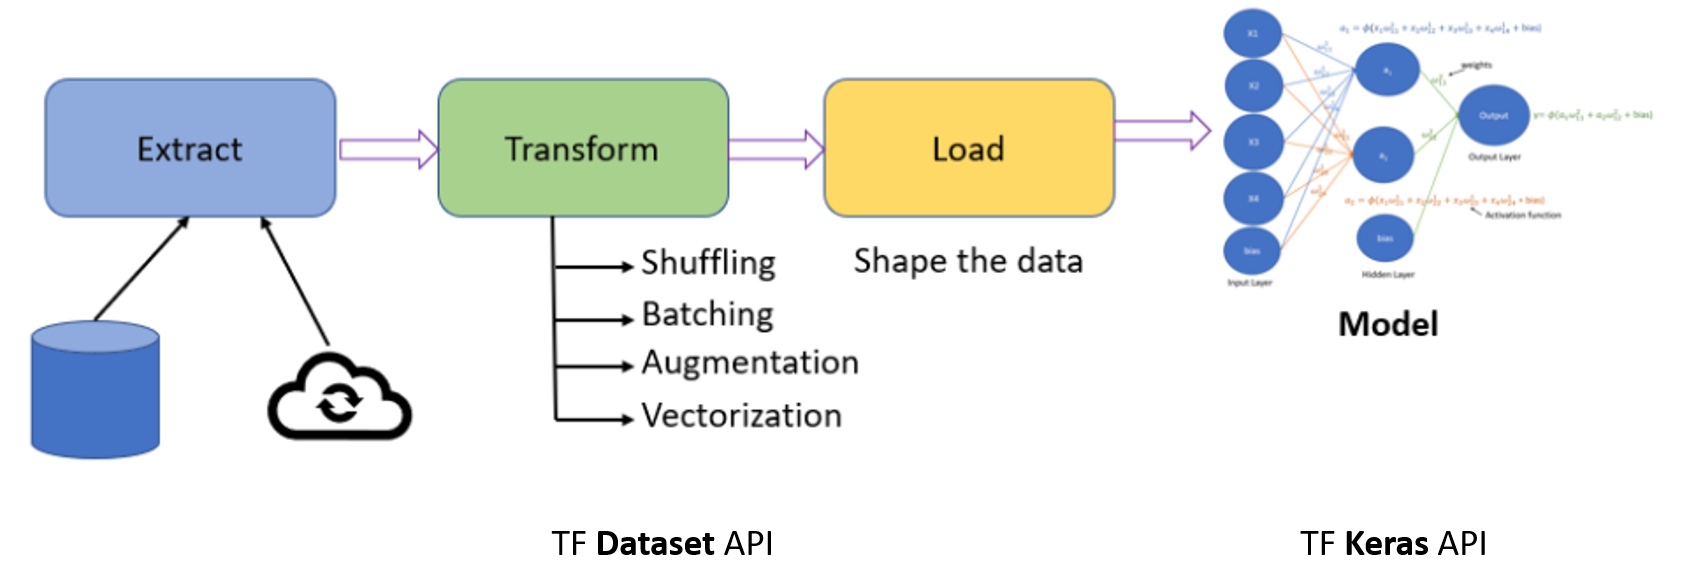

In [30]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [31]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [32]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('trip_start_month', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'5', b'1', b'1', b'3', b'9', b'4', b'9', b'11', b'6', b'9'],
      dtype=object)>), ('trip_start_hour', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'21', b'8', b'19', b'12', b'8', b'18', b'18', b'19', b'20', b'22'],
      dtype=object)>), ('trip_start_day', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'5', b'3', b'3', b'5', b'1', b'0', b'3', b'2', b'6', b'4'],
      dtype=object)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.753304, 40.74375 , 40.735737, 40.77851 ,  0.      , 40.735546,
       40.77097 , 40.736103, 40.76438 , 40.74037 ], dtype=float32)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.97791 , -73.98395 , -74.001854, -73.95631 ,   0.      ,
       -73.985405, -73.96674 , -73.99786 , -73.99582 , -73.994545],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
a

<DatasetV1Adapter shapes: (OrderedDict([(trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (pickup_latitude, (None,)), (pickup_longitude, (None,)), (dropoff_latitude, (None,)), (dropoff_longitude, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(trip_start_month, tf.string), (trip_start_hour, tf.string), (trip_start_day, tf.string), (pickup_latitude, tf.float32), (pickup_longitude, tf.float32), (dropoff_latitude, tf.float32), (dropoff_longitude, tf.float32), (distance, tf.float32)]), tf.float32)>

In [33]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127469 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               127469 non-null  float64
 1   trip_start_month   127469 non-null  object 
 2   trip_start_hour    127469 non-null  object 
 3   trip_start_day     127469 non-null  object 
 4   pickup_latitude    127469 non-null  float64
 5   pickup_longitude   127469 non-null  float64
 6   dropoff_latitude   127469 non-null  float64
 7   dropoff_longitude  127469 non-null  float64
dtypes: float64(5), object(3)
memory usage: 8.8+ MB


In [34]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

# Hyperparameters tuning

### **Model - Training pipeline**

We are going to build a Deep Neural Network which will comprise of following in-model feature engineering techniques:
1. One-Hot encode all categorical attributes
2. Feature cross: Cross-join categorical attributes( ex: Lat cross Lon )
3. Network architecture: Wide( Categorical  ) and Deep( Continuous features )
4. Regularization( Overfit prevention ): L2
5. Uses GPU / TPU as distribution infra

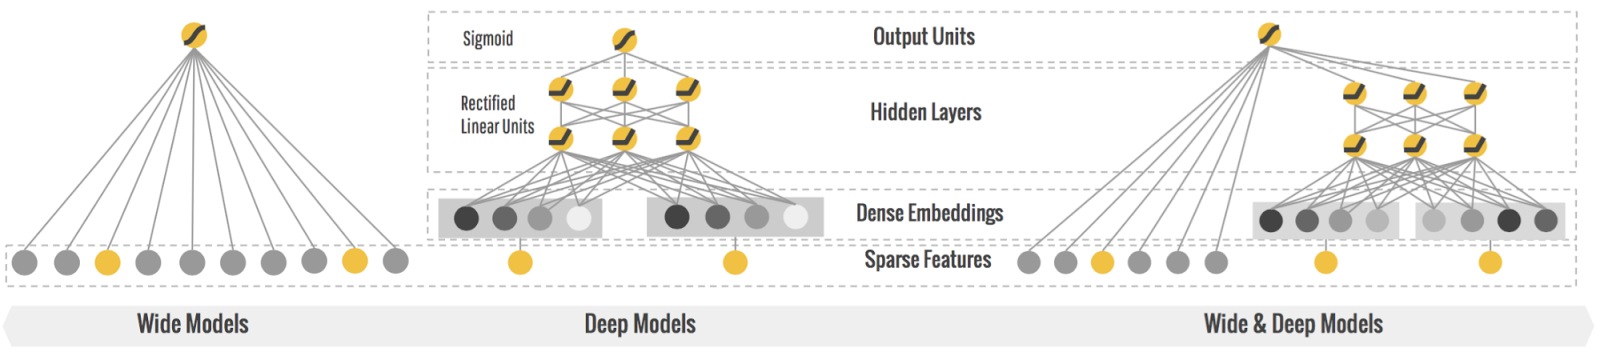

In [35]:
#Create model
params_default = {
    'lr' : 0.002,
    'beta_1' : 0.98,
    'beta_2' : 0.998,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00002))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

# Modified the keras train evaluate model by hyperparameter changes

In [36]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=150):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                patience=6, min_lr=0.00002, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 150,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

#Tuned Keras Model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

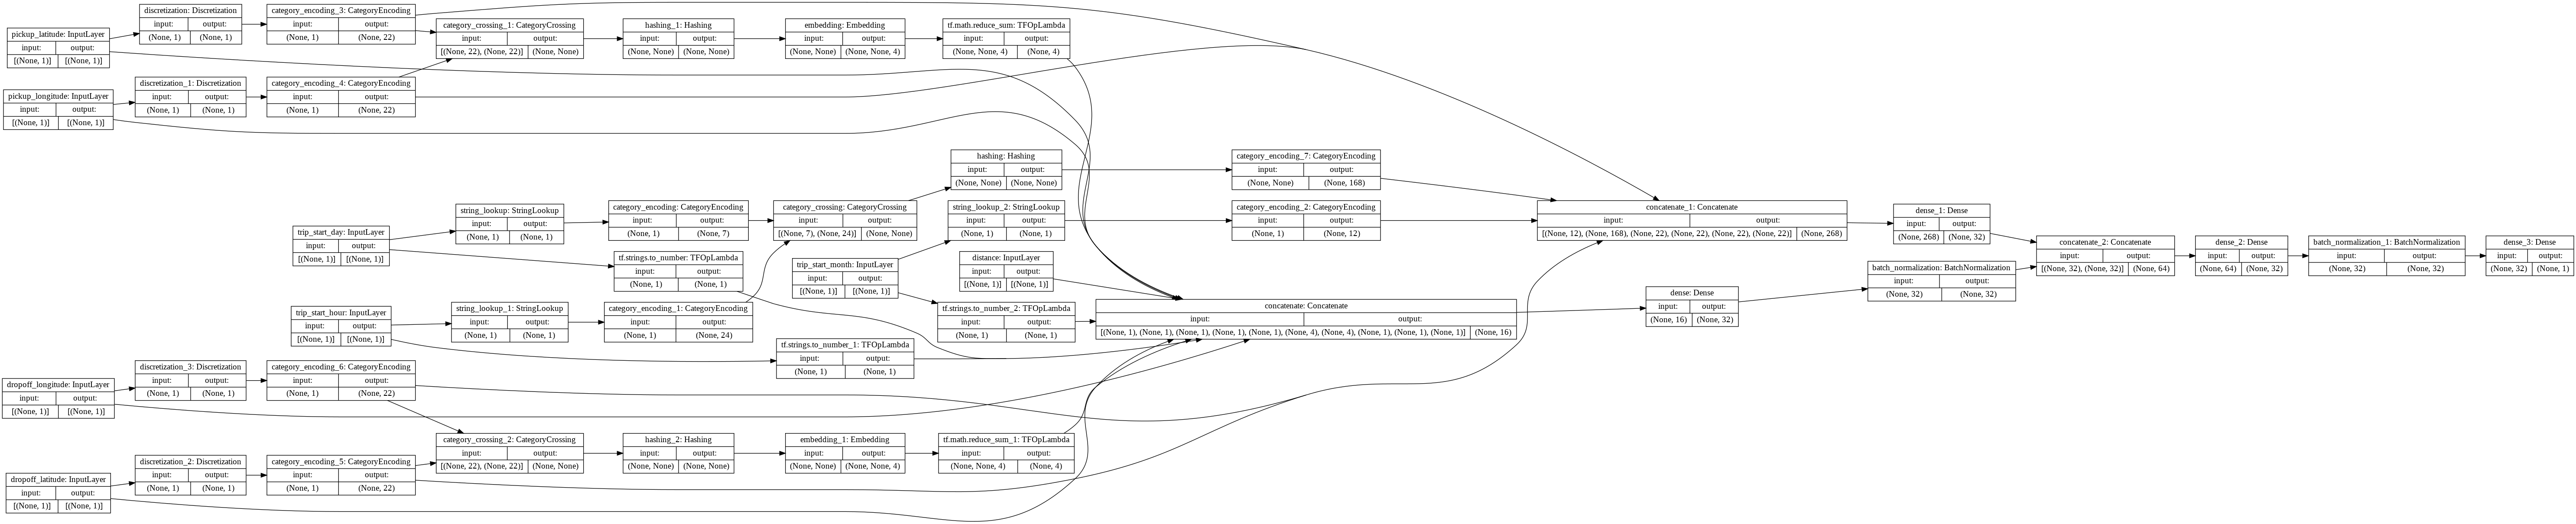

In [37]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

# Modified Epochs Run

In [ ]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 60)

Epoch 1/60
150/150 [==============================] - 58s 357ms/step - loss: 174.5034 - rmse: 13.2026 - val_loss: 145.7284 - val_rmse: 12.0717
Epoch 2/60
150/150 [==============================] - 52s 350ms/step - loss: 80.8402 - rmse: 8.9719 - val_loss: 230.7625 - val_rmse: 15.1908
Epoch 3/60
150/150 [==============================] - 52s 349ms/step - loss: 49.3972 - rmse: 7.0212 - val_loss: 48.2815 - val_rmse: 6.9484
Epoch 4/60
150/150 [==============================] - 52s 347ms/step - loss: 43.2836 - rmse: 6.5743 - val_loss: 40.7075 - val_rmse: 6.3802
Epoch 5/60
150/150 [==============================] - 52s 348ms/step - loss: 35.4122 - rmse: 5.9493 - val_loss: 70.4638 - val_rmse: 8.3942
Epoch 6/60
150/150 [==============================] - 52s 345ms/step - loss: 38.4125 - rmse: 6.1913 - val_loss: 56.4760 - val_rmse: 7.5150
Epoch 7/60
150/150 [==============================] - 52s 346ms/step - loss: 32.8828 - rmse: 5.7297 - val_loss: 52.5218 - val_rmse: 7.2472
Epoch 8/60
150/150 [=

### **Serving the model**

In [ ]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

In [ ]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

In [ ]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

In [ ]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

In [ ]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text